In [ ]:
pip install swig

In [ ]:
pip install gymnasium[box2d]

In [ ]:
pip install moviepy

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
import os
from gym.wrappers import RecordVideo

In [ ]:
# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
        # Move the model to the device
        self.to(device)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc3(x)
        std = torch.exp(self.log_std)
        return mean, std

# Value network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        
        # Move the model to the device
        self.to(device)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [ ]:
# PPO agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr, gamma, eps_clip, K_epochs):
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.policy_old = PolicyNetwork(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.value = ValueNetwork(state_dim).to(device)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

    def select_action(self, state):
        if len(state) != 24:
            print(f"Debug: State received: {state}")
            raise ValueError(f"Expected state of length 24, got {len(state)}")
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            mean, std = self.policy_old(state)
        dist = Normal(mean, std)
        action = dist.sample()
        action_logprob = dist.log_prob(action).sum()
        return action.detach().cpu().numpy()[0], action_logprob.detach().cpu().numpy()

    def update(self, memory):
        # Convert lists to tensors
        states = torch.FloatTensor(np.array(memory['states'])).to(device)
        actions = torch.FloatTensor(np.array(memory['actions'])).to(device)
        old_logprobs = torch.FloatTensor(np.array(memory['logprobs'])).to(device)
        rewards = torch.FloatTensor(np.array(memory['rewards'])).to(device)
        
        # Compute discounted rewards
        discounted_rewards = []
        R = 0
        for reward in reversed(rewards):
            R = reward + self.gamma * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)
        
        # Normalize the rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            mean, std = self.policy(states)
            dist = Normal(mean, std)
            new_logprobs = dist.log_prob(actions).sum(dim=-1)
            entropy = dist.entropy().sum(dim=-1)
            
            # Ratios for policy update
            ratios = torch.exp(new_logprobs - old_logprobs)
            
            # Compute advantages
            values = self.value(states).squeeze()
            advantages = discounted_rewards - values.detach()
            
            # Surrogate loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy.mean()
            
            # Optimize policy network
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()
            
            # Value loss
            value_loss = nn.MSELoss()(values, discounted_rewards)
            
            # Optimize value network
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
        
        # Update old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

In [ ]:
def train(env, agent, n_episodes, max_timesteps, update_timestep):
    memory = {'states': [], 'actions': [], 'logprobs': [], 'rewards': []}
    episode_rewards = []
    best_episode = {'number': 0, 'reward': -float('inf')}  # Track the best episode

    timestep = 0
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for t in range(max_timesteps):
            action, action_logprob = agent.select_action(state)
            
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, done, truncated, info = step_result
                done = done or truncated
            else:
                next_state, reward, done, info = step_result
            
            memory['states'].append(state)
            memory['actions'].append(action)
            memory['logprobs'].append(action_logprob)
            memory['rewards'].append(reward)
            
            state = next_state
            episode_reward += reward
            timestep += 1
            
            if timestep % update_timestep == 0:
                agent.update(memory)
                memory = {'states': [], 'actions': [], 'logprobs': [], 'rewards': []}
                timestep = 0
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        print(f"Episode {episode+1}, Reward: {episode_reward}")
        
        # Check if this episode has the best reward
        if episode_reward > best_episode['reward']:
            best_episode['number'] = episode
            best_episode['reward'] = episode_reward
    
    print(f"Best episode: {best_episode['number']+1}, Reward: {best_episode['reward']}")
    
    return episode_rewards

In [ ]:
# Set up environment and agent
env = gym.make('BipedalWalker-v3', render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPOAgent(state_dim, action_dim, lr=3e-4, gamma=0.99, eps_clip=0.2, K_epochs=4)

In [ ]:
# Train the agent
n_episodes = 3000
max_timesteps = 2000
update_timestep = 2000

episode_rewards = train(env, agent, n_episodes, max_timesteps, update_timestep)

# Plot rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards')
plt.show()

# Save the trained models
torch.save(agent.policy.state_dict(), 'ppo_policy.pth')
torch.save(agent.value.state_dict(), 'ppo_value.pth')

Episode 1, Reward: -101.26500916539443
Episode 2, Reward: -113.72023926019358
Episode 3, Reward: -125.93408236821058
Episode 4, Reward: -182.70244593523694
Episode 5, Reward: -118.7767087444189
Episode 6, Reward: -109.16188329141403
Episode 7, Reward: -103.29180190255846
Episode 8, Reward: -101.99836042748143
Episode 9, Reward: -97.71536838872231
Episode 10, Reward: -114.12148379663441
Episode 11, Reward: -118.60838161332471
Episode 12, Reward: -98.27108774210264
Episode 13, Reward: -98.07521784729218
Episode 14, Reward: -108.5896940344808
Episode 15, Reward: -109.09804392572181
Episode 16, Reward: -171.98831059700427
Episode 17, Reward: -115.37185223404815
Episode 18, Reward: -78.38828026458002
Episode 19, Reward: -109.85261945325074
Episode 20, Reward: -106.77345648417746
Episode 21, Reward: -112.81518158437126
Episode 22, Reward: -114.37936195291392
Episode 23, Reward: -122.30357629678147
Episode 24, Reward: -105.80939806556702
Episode 25, Reward: -112.7551624234772
Episode 26, Rewa

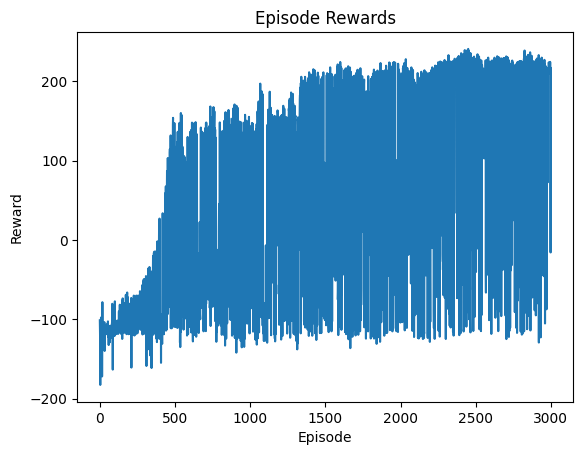

Best episode video saved to ./video_eval2/best_episode.mp4


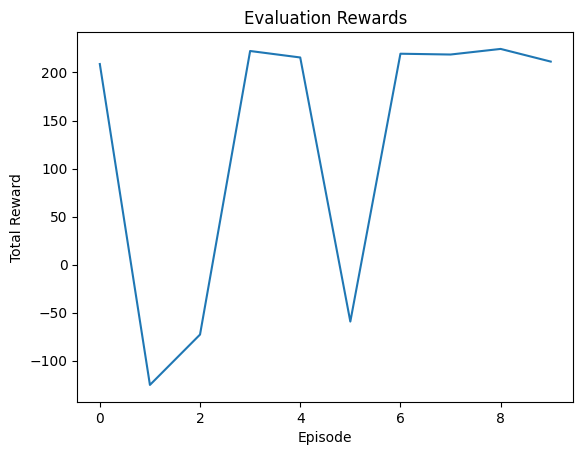

In [8]:
# Save frames as video with episode number
def save_frames_as_video(frames, video_path, episode_number, fps=30):
    import cv2
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path + f'_episode_{episode_number}.mp4', fourcc, fps, (width, height))

    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    video.release()

# Evaluate the trained agent
def evaluate_agent(env, agent, episodes=10, video_dir='./video_eval2/'):
    total_rewards = []
    best_reward = -float('inf')
    best_episode_frames = []
    best_episode_number = None

    for i in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        frames = []

        while True:
            action, _ = agent.select_action(state)
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, done, truncated, info = step_result
                done = done or truncated
            else:
                next_state, reward, done, info = step_result

            episode_reward += reward
            state = next_state

            frame = env.render()
            if frame is not None:
                frames.append(frame)

            if done:
                total_rewards.append(episode_reward)
                if episode_reward > best_reward:
                    best_reward = episode_reward
                    best_episode_frames = frames
                    best_episode_number = i
                break

    if best_episode_frames:
        # Save the video of the best episode
        save_frames_as_video(best_episode_frames, video_dir + 'best_episode', best_episode_number)
        print(f"Best episode video saved to {os.path.join(video_dir, 'best_episode.mp4')}")
    else:
        print("No frames to save")

    env.close()
    return total_rewards

# Ensure the video directory exists
os.makedirs('./video_eval2/', exist_ok=True)

# Evaluate and visualize
rewards = evaluate_agent(env, agent)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Evaluation Rewards')
plt.show()